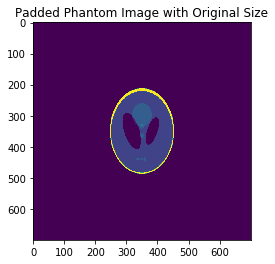

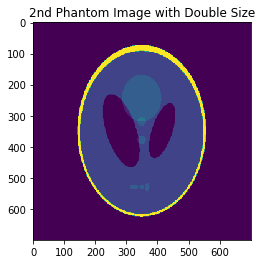

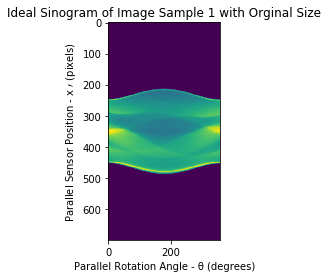

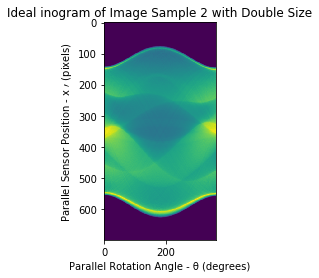

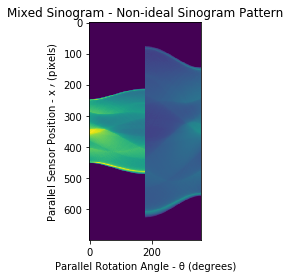

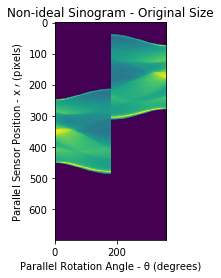

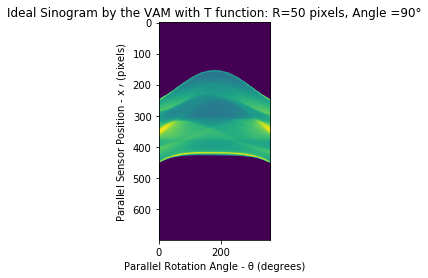

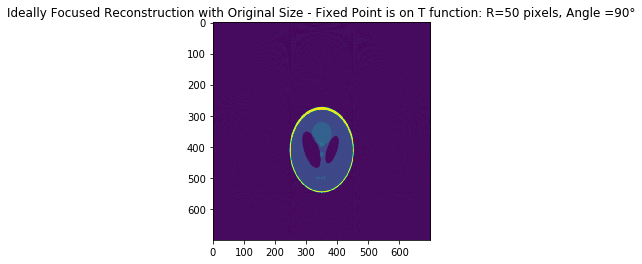

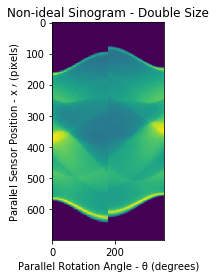

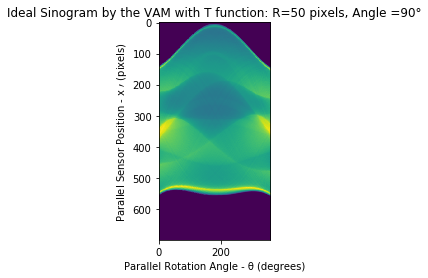

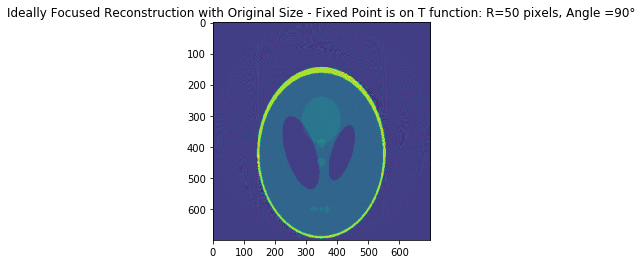

In [44]:
# Copyright 2017 Kyungtaek Jun
# Licensed under the MIT License
# https://www.mit.edu/~amini/LICENSE.md

##############################################################################
### Virtual Alignment Method for Regular Elastic Sample with Phantom Image ###
###                              PLOS ONE, 2018                            ###
##############################################################################

# module import part
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon, iradon, iradon_sart


# the position of fixed point in the polar coordinate system
##############################################################
fp_r = 50           # Radius from the center of Reconstrucion
fp_phi = 45          # Angle (degree)
##############################################################


#%%% initial set up
max_angle = 180           #% rotating angle
projections = 360         #% number of projection images
dtheta = max_angle/projections
theta = np.arange(0, max_angle, dtheta)
 
# make phantom image by 500*500 pixels
pnx = 300      #      % size of phantom
P = shepp_logan_phantom()
P = rescale(P, scale=0.75)

# padding 100 pixels around the image
Pad = 200
inx = pnx + 2*Pad
iny = inx
IS1 = np.zeros((inx,iny))            #;     % Initial set up for Image Sample

for j in range(Pad, iny - Pad):
    for i in range(Pad, inx - Pad):
        temp_val = P[i-Pad, j-Pad]

        if temp_val < 0:          #    % remove negative values for making video
            IS1[i,j] = 0
        else:
            IS1[i,j] = temp_val
            
plt.figure()
plt.title('Padded Phantom Image with Original Size');
plt.imshow(IS1)

####################################
### Set Up second Phantom Image  ###
####################################
IS2 = np.zeros((inx,iny))            #     % Initial set up for Image Sample

qPad = Pad/4
qPad = int(qPad)
for j in range( qPad, iny-qPad):
    for i in range(qPad, inx-qPad):
        IS2[i,j] = IS1[ int(np.floor((i-qPad-1)/2))+Pad+1, int(np.floor((j-qPad-1)/2))+Pad+1]/4

plt.figure()
plt.title('2nd Phantom Image with Double Size');
plt.imshow(IS2)

####################################
###        Make Sinograms        ###
####################################
# 1st Sinogram with original size
isino1 = np.zeros((inx,0))
for k in range(projections):
    sino_1 = radon(IS1, theta = [theta[k]], circle=True)
    isino1 = np.hstack([isino1, sino_1])

[sino_nx, sino_ny] = isino1.shape[:2]

plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Ideal Sinogram of Image Sample 1 with Orginal Size')
plt.imshow(isino1)

# 2nd Sinogram with double size
isino2 = np.zeros((inx,0))
for k in range(projections):
    sino2 = radon(IS2, theta=[theta[k]], circle=True)
    isino2 = np.hstack([isino2, sino2])
    
plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Ideal inogram of Image Sample 2 with Double Size')
plt.imshow(isino2)

#% 3rd Mixed sinogram
half_ny = np.round(sino_ny/2)
half_nx = np.floor(sino_nx/2)
msino = np.zeros((sino_nx, sino_ny))
for j in range(sino_ny):
    for i in range(sino_nx):
        if j <= half_ny:
            msino[i,j] = isino1[i,j]
        else:
            msino[i,j] = isino2[i,j]

plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Mixed Sinogram - Non-ideal Sinogram Pattern')
plt.imshow(msino)

##########################################################
###  Make 4 & 5th ideal sinograms with different size  ###
##########################################################
# 4th Ideal Sinogram
nsino_ori = np.zeros((sino_nx, sino_ny))
for j in range(sino_ny):
    for i in range(sino_nx):
        if j <= half_ny:
            nsino_ori[i,j] = msino[i, j]
        else:
            if i <= half_nx - 1:
                nsino_ori[i, j] = (msino[2*i-1, j] + msino[2*i, j])

plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Non-ideal Sinogram - Original Size')
plt.imshow(nsino_ori)

# T function for original size
isino_ori = np.zeros((sino_nx, sino_ny))
for j in range(projections):
    for i in range(sino_nx):
        isino_ori[i,j]= 0                  # Ideal Sinogram with Original Size

deg_to_rad = np.pi/180
Virtural_RA = np.round(sino_nx/2)          # Change Virtural_RA value -> change the size of Reconstruction ( required change of sino_nx value )
for j in range(projections):
    pjtd_CA_x = 0
    total_MAC = 0

    for i in range(sino_nx):
        pjtd_CA_x = pjtd_CA_x + i*nsino_ori[i,j]
        total_MAC = total_MAC + nsino_ori[i,j]
   

    pjtd_CA_x = pjtd_CA_x/total_MAC                     # Calculate CA (CM)
    T = fp_r*np.cos((j*dtheta-fp_phi)*deg_to_rad)       # T function with Radius and Angle
    pjtd_CA_x = pjtd_CA_x + T

    ceil_CA_x = int(np.ceil(pjtd_CA_x))
    floor_CA_x = int(np.floor(pjtd_CA_x))

    right_ratio = pjtd_CA_x - floor_CA_x
    left_ratio = ceil_CA_x - pjtd_CA_x

    if left_ratio == 0:
        left_ratio = 1

    move = Virtural_RA - floor_CA_x

    for i in range(1,sino_nx):
        if i-1+move <= 1 or i-1+move >= sino_nx:
            continue
        else:
            isino_ori[i-1+int(move),j] = nsino_ori[i-1,j]*left_ratio + nsino_ori[i,j]*right_ratio


plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Ideal Sinogram by the VAM with T function: R='+str(fp_r)+' pixels, Angle ='+str(fp_phi)+'\u00B0')
plt.imshow(isino_ori)

Recon_ori = iradon(isino_ori, theta=theta, circle=True)
plt.figure()
plt.title('Ideally Focused Reconstruction with Original Size - Fixed Point is on T function: R='+str(fp_r)+' pixels, Angle ='+str(fp_phi)+'\u00B0')
plt.imshow(Recon_ori)

#% 5th Ideal Sinogram
q_nx = int(np.floor(sino_nx/6))
nsino_db = np.zeros((sino_nx, sino_ny))
for j in range(sino_ny):
    for i in range(sino_nx):
        if j > half_ny:
            nsino_db[i,j] = msino[i,j]
        else:
            if i <= half_nx + 40 and i > 50:
                temp_val = (msino[q_nx + i, j])/2
                nsino_db[2*i - 1 - 100, j] = temp_val
                nsino_db[2*i - 100, j] = temp_val

plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Non-ideal Sinogram - Double Size')
plt.imshow(nsino_db)

# T function for original size
isino_db = np.zeros((sino_nx, sino_ny))
for j in range(projections):
    for i in range(sino_nx):
        isino_db[i,j] = 0        #% Ideal Sinogram with Expanded Size

for j in range(projections):
    pjtd_CA_x = 0
    total_MAC = 0

    for i in range(sino_nx):
        pjtd_CA_x = pjtd_CA_x + i*nsino_db[i,j]
        total_MAC = total_MAC + nsino_db[i,j]

    pjtd_CA_x = pjtd_CA_x/total_MAC                      #% Calculate CA (CM)
    T = fp_r*np.cos((j*dtheta-fp_phi)*deg_to_rad)       #% T function with Radius and Angle
    pjtd_CA_x = pjtd_CA_x + T
   
    ceil_CA_x = np.ceil(pjtd_CA_x)
    floor_CA_x = np.floor(pjtd_CA_x)

    right_ratio = pjtd_CA_x - floor_CA_x
    left_ratio = ceil_CA_x - pjtd_CA_x

    if left_ratio == 0:
        left_ratio = 1

    move = Virtural_RA - floor_CA_x
 
    for i in range(1,sino_nx):
        if i-1+move <= 1 or i-1+move >= sino_nx:
            continue
        else:
            isino_db[i-1+int(move),j] = nsino_db[i-1,j]*left_ratio + nsino_db[i,j]*right_ratio

plt.figure()
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.title('Ideal Sinogram by the VAM with T function: R='+str(fp_r)+' pixels, Angle ='+str(fp_phi)+'\u00B0')
plt.imshow(isino_db)

Recon_db = iradon(isino_db, theta=theta, circle=True)
plt.figure()
plt.title('Ideally Focused Reconstruction with Original Size - Fixed Point is on T function: R='+str(fp_r)+' pixels, Angle ='+str(fp_phi)+'\u00B0')
plt.imshow(Recon_db)
